In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
from functools import reduce
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table

## chose where to sample LFP

In [3]:
#################################################

lfp_location = ''
# lfp_location = '-other-tetrode'
# lfp_location = '-other-drive'

##################################################

In [4]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("stimulus-spike-lfp-response" + lfp_location)
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [5]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

In [6]:
data, labels, colors, queries = load_data_frames()

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [7]:
lfp_action = actions['stimulus-spike-lfp-response' + lfp_location]
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [8]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
lfp_results = lfp_results.drop('unit_id', axis=1)

In [9]:
data = data.merge(lfp_results, how='left')

In [10]:
data['stim_strength'] = data.stim_p_max / data.theta_peak

In [11]:
keys = [
    'theta_energy',
    'theta_peak',
    'theta_freq',
    'theta_half_width',
    'theta_vec_len',
    'theta_ang',
    'stim_energy',
    'stim_half_width',
    'stim_p_max',
    'stim_strength',
    'stim_vec_len',
    'stim_ang'
]

In [12]:
results, labels = make_paired_tables(data, keys)

In [13]:
results['gridcell']['theta_peak']

,entity,unit_idnum,channel_group,date,Baseline I,11 Hz,Baseline II,30 Hz
51,1833,8,0,20719,0.244278,NaN,NaN,NaN
85,1833,13,0,20719,NaN,0.039465,0.279382,0.054633
86,1833,14,0,20719,NaN,0.022268,0.448472,NaN
58,1833,23,0,200619,0.280865,NaN,NaN,NaN
127,1833,26,0,200619,NaN,NaN,0.181703,0.038459
...,...,...,...,...,...,...,...,...
139,1849,835,4,150319,NaN,NaN,NaN,0.692552
43,1849,851,5,60319,0.662908,NaN,NaN,NaN
65,1849,932,7,280219,0.050995,NaN,NaN,NaN
74,1849,937,7,280219,NaN,0.131422,NaN,NaN


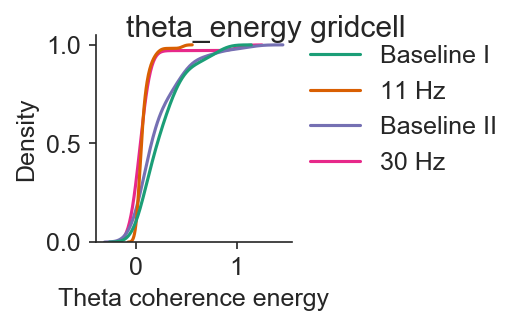

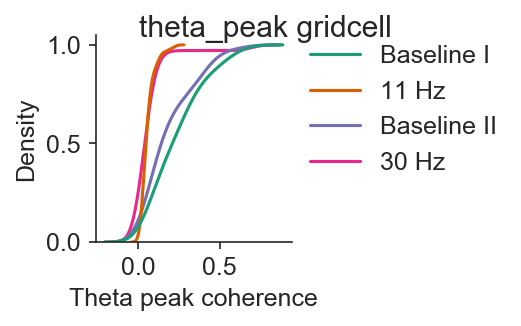

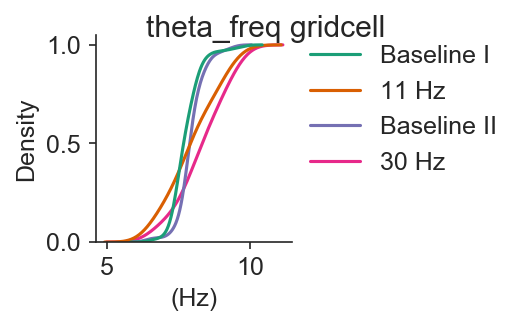

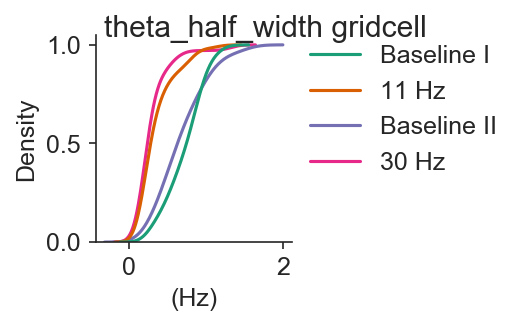

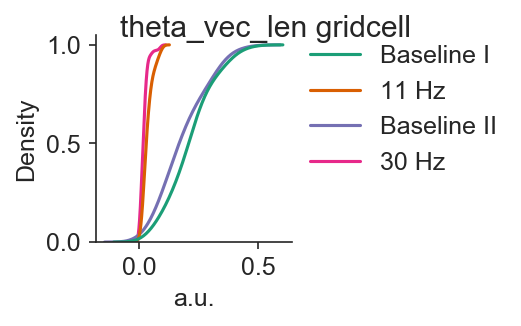

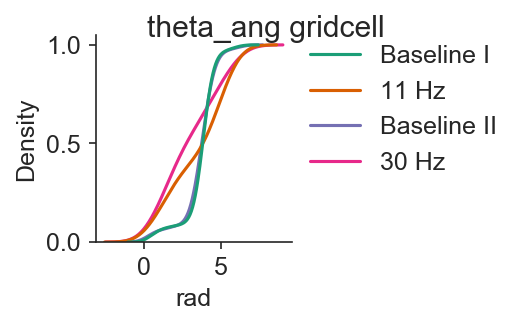

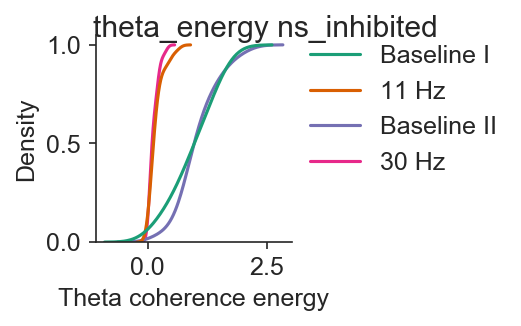

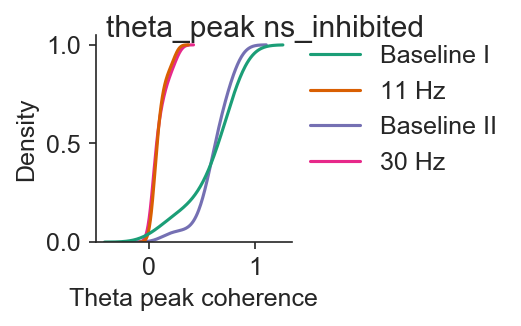

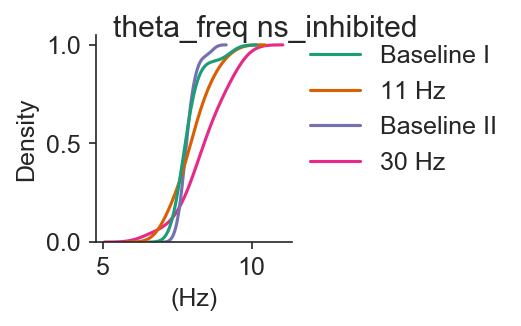

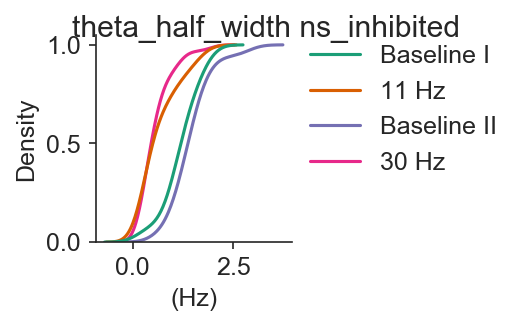

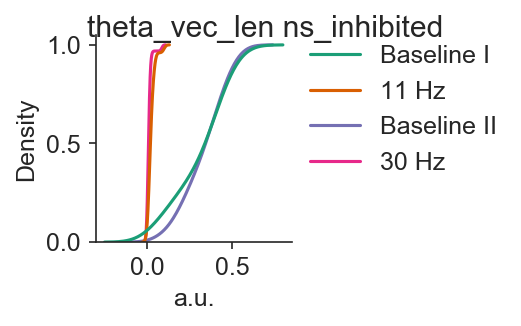

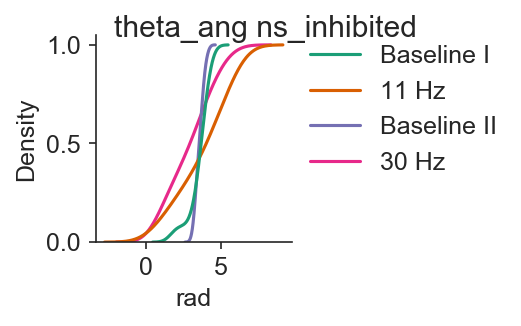

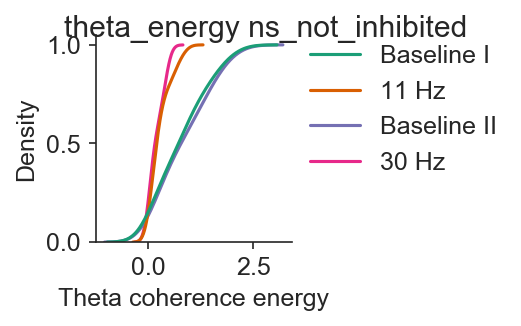

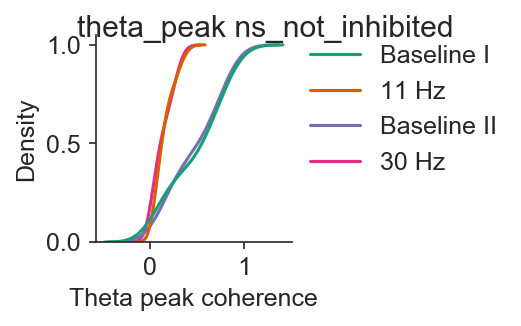

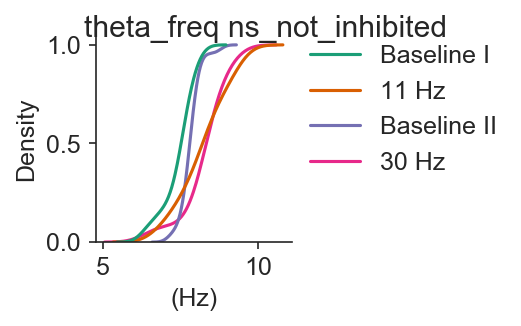

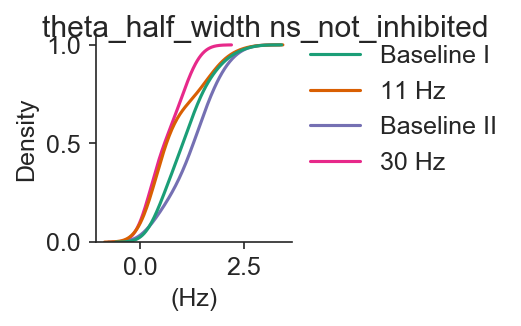

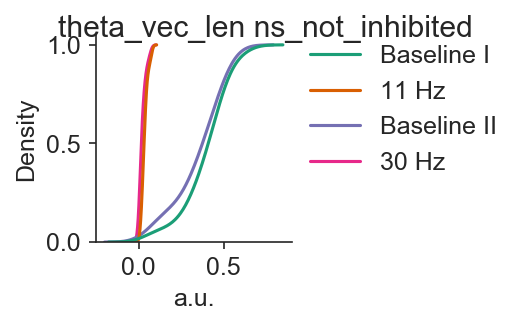

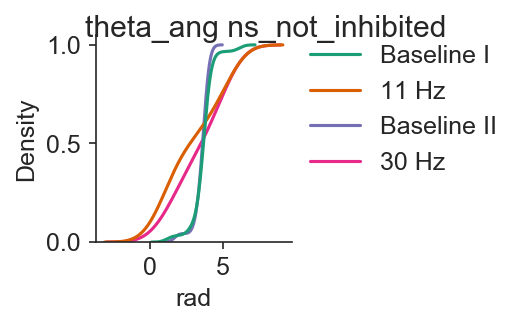

In [14]:
xlabel = {
    'theta_energy': 'Theta coherence energy',
    'theta_peak': 'Theta peak coherence',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
    'theta_vec_len': 'a.u.',
    'theta_ang': 'rad'
}
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in xlabel:
        fig = plt.figure(figsize=(3.7,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors, labels):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

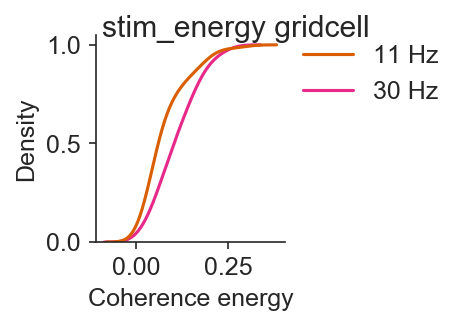

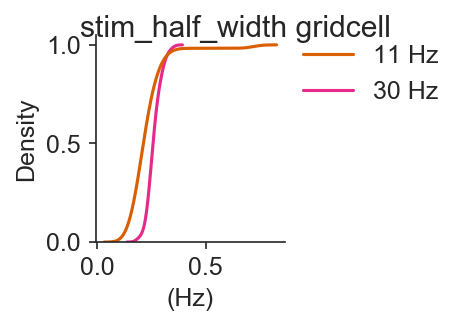

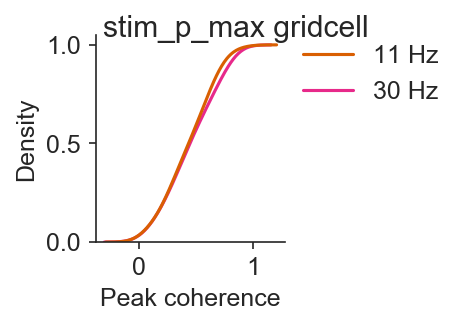

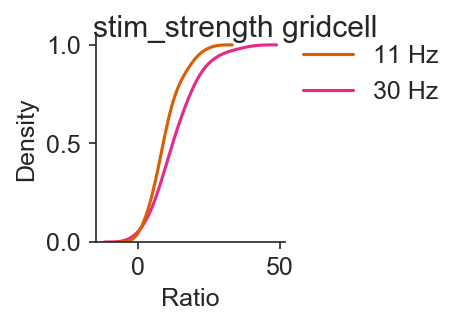

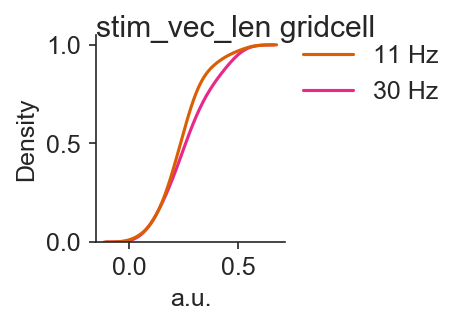

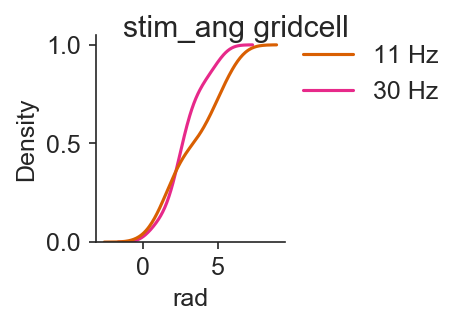

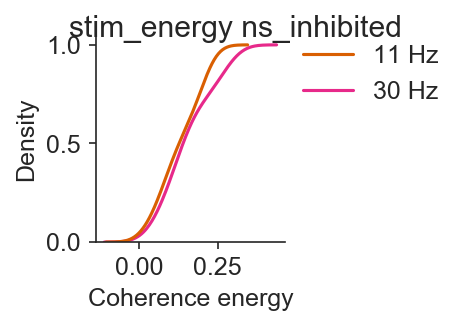

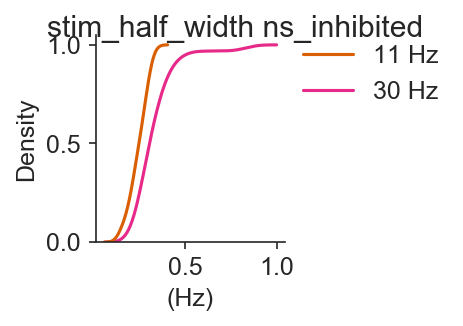

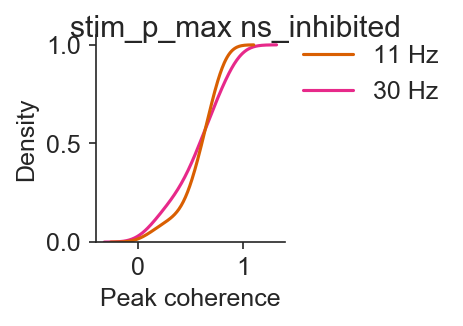

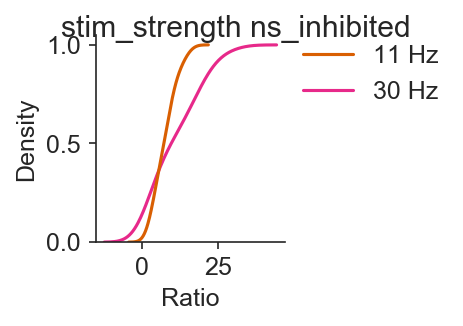

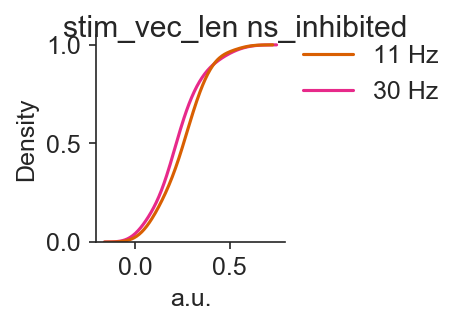

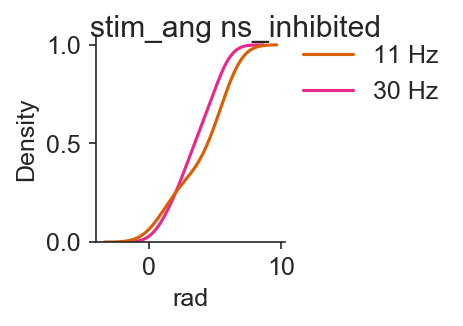

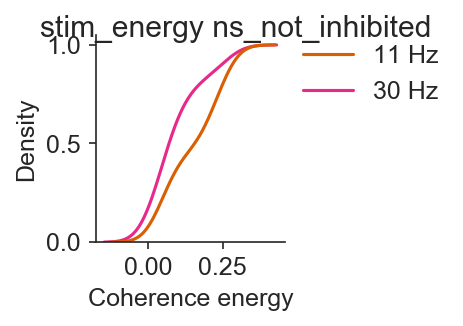

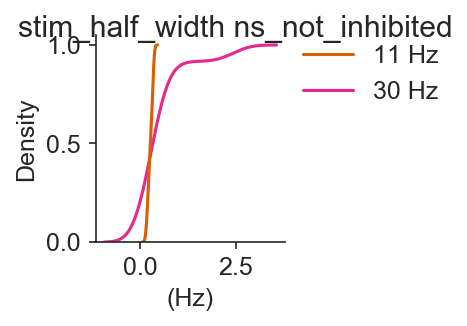

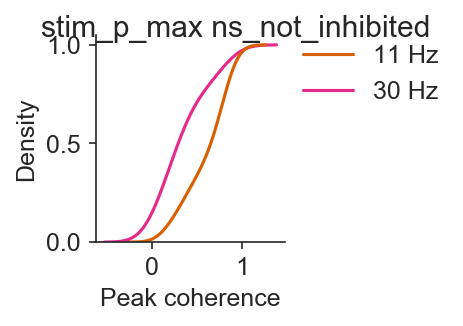

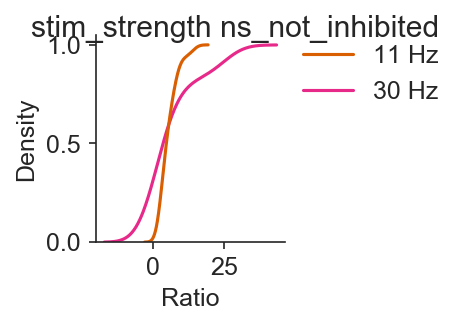

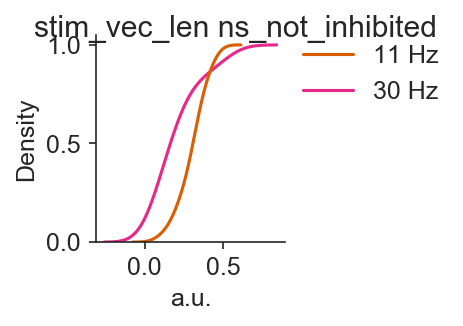

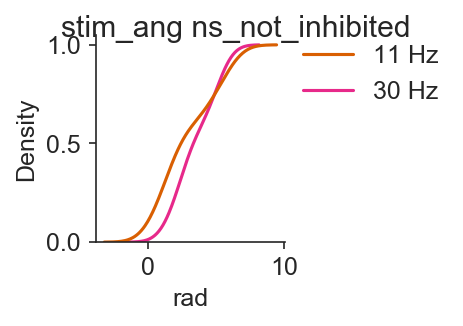

In [15]:
xlabel = {
    'stim_energy': 'Coherence energy',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak coherence',
    'stim_strength': 'Ratio',
    'stim_vec_len': 'a.u.',
    'stim_ang': 'rad'
}
# key = 'theta_energy'
# key = 'theta_peak'
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in xlabel:
        fig = plt.figure(figsize=(3.3,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors[1::2], labels[1::2]):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels[1::2]], cumulative=True, legend=False, palette=colors[1::2], common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

## polar plot

In [16]:
from septum_mec.analysis.statistics import VonMisesKDE

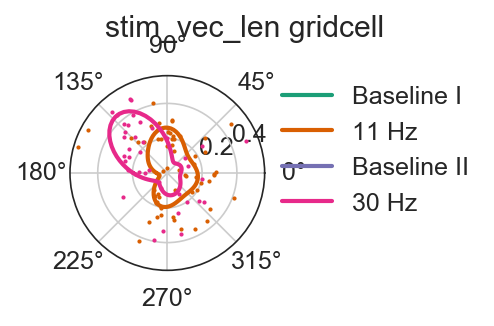

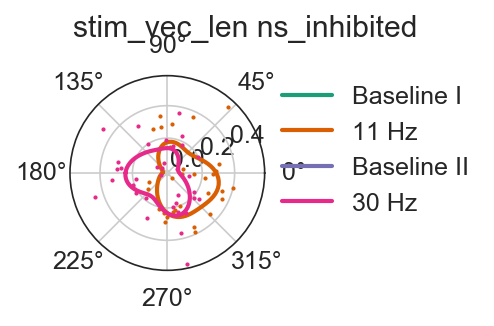

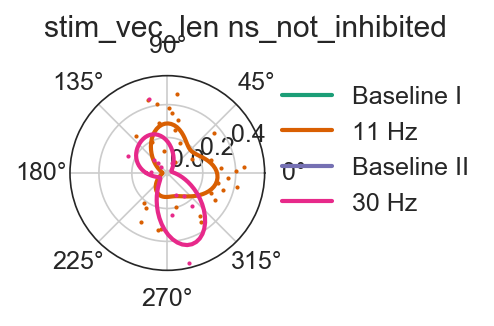

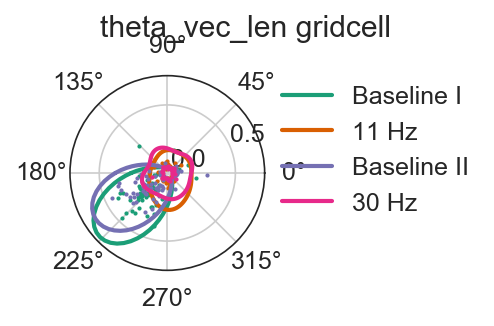

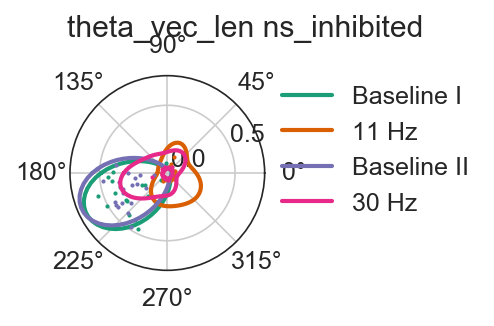

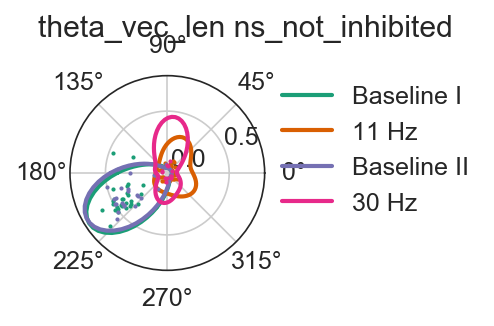

In [17]:
for paradigm in ['stim', 'theta']:
    key = paradigm + '_vec_len'
    for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
        fig = plt.figure(figsize=(3.2,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            data_query = data.query(query + ' and ' + cell_type)
            values = data_query[key].values
            angles = data_query[paradigm + '_ang'].values
            kde = VonMisesKDE(angles, weights=values, kappa=5)
            bins = np.linspace(-np.pi, np.pi, 100)
            plt.polar(bins, kde.evaluate(bins), color=color, lw=2)
            plt.polar(angles, values, color=color, lw=1, ls='none', marker='.', markersize=2)
#             values.hist(
#                 bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
#                 histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=2, label=label))
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
#         plt.grid(False)
        figname = f'spike-lfp-polar-plot-{paradigm}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [18]:
stats = {}
for cell_type, result in results.items():
    stats[cell_type], _ = make_statistics_table(result, labels)

In [19]:
stats['gridcell']

,Theta energy,Theta peak,Theta freq,Theta half width,Theta vec len,Theta ang,Stim energy,Stim half width,Stim p max,Stim strength,Stim vec len,Stim ang
Baseline I,2.9e-01 ± 3.5e-02 (63),2.4e-01 ± 2.6e-02 (63),7.8e+00 ± 7.0e-02 (63),7.0e-01 ± 3.9e-02 (63),2.3e-01 ± 1.3e-02 (63),3.6e+00 ± 1.3e-01 (63),NaN,NaN,NaN,NaN,NaN,NaN
Normality Baseline I,"1.5e+01, 6.9e-04","5.6e+00, 6.2e-02","2.9e+01, 5.3e-07","3.2e+00, 2.0e-01","1.2e+00, 5.6e-01","3.6e+01, 1.3e-08",NaN,NaN,NaN,NaN,NaN,NaN
11 Hz,8.7e-02 ± 1.2e-02 (56),6.9e-02 ± 6.3e-03 (56),7.8e+00 ± 1.3e-01 (56),3.5e-01 ± 3.0e-02 (56),3.8e-02 ± 3.3e-03 (56),3.6e+00 ± 2.3e-01 (56),9.7e-02 ± 1.0e-02 (58),2.3e-01 ± 8.5e-03 (58),4.7e-01 ± 3.2e-02 (58),8.9e+00 ± 7.4e-01 (58),2.5e-01 ± 1.6e-02 (58),3.2e+00 ± 2.5e-01 (58)
Normality 11 Hz,"7.0e+01, 6.7e-16","3.7e+01, 1.0e-08","5.9e+00, 5.1e-02","2.3e+01, 1.0e-05","1.3e+01, 1.3e-03","2.6e+01, 2.1e-06","1.9e+01, 8.0e-05","8.9e+01, 5.7e-20","3.0e+00, 2.2e-01","4.8e+00, 8.9e-02","5.1e+00, 7.8e-02","4.6e+01, 9.7e-11"
Baseline II,3.3e-01 ± 3.7e-02 (46),2.8e-01 ± 2.6e-02 (46),8.1e+00 ± 5.0e-02 (46),6.6e-01 ± 5.0e-02 (46),2.4e-01 ± 1.6e-02 (46),3.7e+00 ± 1.0e-01 (46),NaN,NaN,NaN,NaN,NaN,NaN
Normality Baseline II,"2.8e+01, 7.1e-07","8.2e+00, 1.6e-02","1.0e+01, 6.3e-03","4.2e+00, 1.2e-01","2.8e+00, 2.5e-01","2.7e+01, 1.7e-06",NaN,NaN,NaN,NaN,NaN,NaN
30 Hz,1.6e-01 ± 5.4e-02 (35),1.2e-01 ± 3.7e-02 (35),8.3e+00 ± 1.6e-01 (35),4.2e-01 ± 6.3e-02 (35),1.8e-02 ± 3.1e-03 (35),2.6e+00 ± 3.2e-01 (35),1.0e-01 ± 1.0e-02 (33),2.6e-01 ± 6.0e-03 (33),4.3e-01 ± 3.8e-02 (33),1.3e+01 ± 1.3e+00 (33),2.6e-01 ± 1.8e-02 (33),2.5e+00 ± 2.2e-01 (33)
Normality 30 Hz,"8.1e+01, 2.9e-18","7.8e+01, 9.1e-18","1.3e+00, 5.2e-01","5.1e+01, 7.9e-12","3.9e+01, 3.4e-09","9.2e+00, 1.0e-02","1.3e+00, 5.2e-01","2.4e+00, 3.0e-01","4.7e+00, 9.5e-02","5.6e+00, 5.9e-02","1.8e+00, 4.0e-01","4.9e-01, 7.8e-01"
LMM Baseline I - 11 Hz,"6.4e-194 [1.9e-01, 2.1e-01]","8.8e-09 [1.2e-01, 2.4e-01]","3.3e-01 [-6.6e-01, 2.2e-01]","5.1e-13 [2.7e-01, 4.8e-01]","2.5e-06 [1.1e-01, 2.8e-01]","6.4e-01 [-6.2e-01, 1.0e+00]",NaN,NaN,NaN,NaN,NaN,NaN
LMM Baseline I - Baseline II,"1.8e-01 [-1.4e-01, 2.6e-02]",NaN,"6.4e-02 [-1.5e-02, 5.3e-01]",NaN,"4.9e-02 [-7.8e-02, -1.8e-04]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

In [21]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

# psd plots

In [22]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [23]:
coher = pd.read_feather(output_path / 'data' / 'coherence.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [24]:
freq = freqs.T.iloc[0].values

mask = (freq < 100)

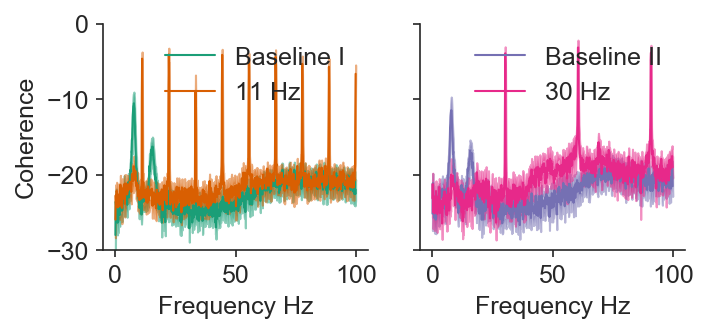

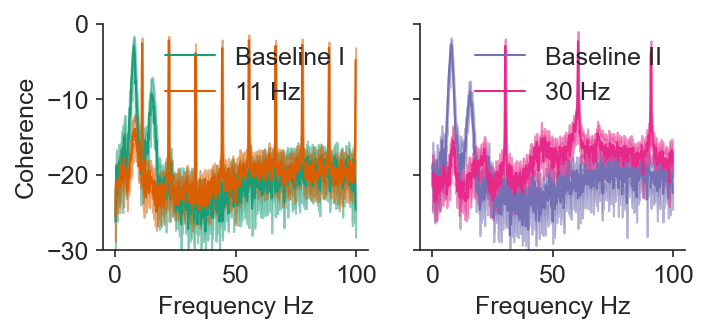

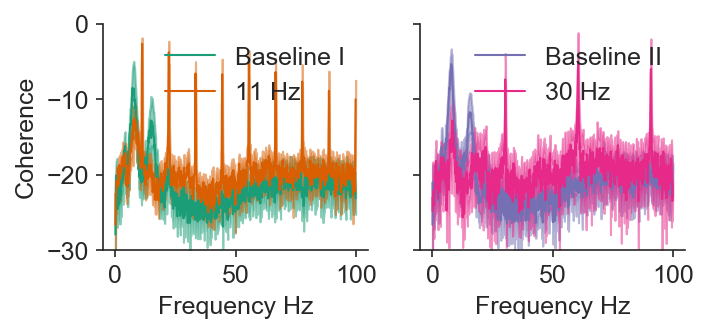

In [25]:
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
    axs = axs.repeat(2)
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = coher.loc[mask, selection].dropna(axis=1).to_numpy()
        values = 10 * np.log10(values)
        plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
    #     ax.set_title(titles[i])
        ax.set_xlabel('Frequency Hz')
        ax.legend(frameon=False)
        ax.set_ylim(-30, 0)
    axs[0].set_ylabel('Coherence')
    despine()
    figname = f'spike-lfp-coherence-{cell_type}'.replace(' ', '-')
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# NSni vs NSi analysis

In [26]:
nsi_vs_nsni = {}
for key in keys:
    df = pd.DataFrame()
    dfs = [results[k][key].loc[:, ['entity', 'unit_idnum', 'Baseline I']].rename({'Baseline I': k}, axis=1) for k in ['ns_inhibited', 'ns_not_inhibited']]
    df = pd.merge(*dfs, on=['entity', 'unit_idnum'], how='outer')
    nsi_vs_nsni[key] = df

In [27]:
nsi_vs_nsni.keys()

dict_keys(['theta_energy', 'theta_peak', 'theta_freq', 'theta_half_width', 'theta_vec_len', 'theta_ang', 'stim_energy', 'stim_half_width', 'stim_p_max', 'stim_strength', 'stim_vec_len', 'stim_ang'])

In [28]:
nsi_vs_nsni['theta_energy']

,entity,unit_idnum,ns_inhibited,ns_not_inhibited
0,1833,19,NaN,NaN
1,1833,27,NaN,NaN
2,1833,34,NaN,NaN
3,1833,40,1.32218,NaN
4,1833,42,NaN,NaN
...,...,...,...,...
118,1849,899,NaN,1.502606
119,1849,907,NaN,0.025392
120,1849,908,NaN,0.023557
121,1849,911,NaN,NaN


In [29]:
from septum_mec.analysis.statistics import LMM

In [30]:
LMM(nsi_vs_nsni['theta_energy'], 'ns_inhibited', 'ns_not_inhibited', 'theta_energy')

(0.3025793385117762,
 -0.9786980617843778,
 0.3040092130809261,
 <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f0e687f7208>)

In [31]:
stat, stat_vals = make_statistics_table(nsi_vs_nsni, ['ns_inhibited', 'ns_not_inhibited'], wilcoxon_test=False)

In [32]:
stat

,Theta energy,Theta peak,Theta freq,Theta half width,Theta vec len,Theta ang,Stim energy,Stim half width,Stim p max,Stim strength,Stim vec len,Stim ang
ns_inhibited,9.9e-01 ± 1.6e-01 (12),5.9e-01 ± 7.2e-02 (12),7.9e+00 ± 1.1e-01 (12),1.3e+00 ± 1.3e-01 (12),3.1e-01 ± 4.6e-02 (12),3.3e+00 ± 2.3e-01 (12),NaN,NaN,NaN,NaN,NaN,NaN
Normality ns_inhibited,"9.2e-01, 6.3e-01","5.6e+00, 6.2e-02","2.2e+01, 1.7e-05","2.2e+00, 3.3e-01","1.8e+00, 4.1e-01","1.8e+01, 1.5e-04",NaN,NaN,NaN,NaN,NaN,NaN
ns_not_inhibited,5.3e-01 ± 9.9e-02 (30),3.6e-01 ± 5.6e-02 (30),7.6e+00 ± 1.0e-01 (30),9.9e-01 ± 8.8e-02 (30),2.9e-01 ± 3.3e-02 (30),3.1e+00 ± 2.2e-01 (30),NaN,NaN,NaN,NaN,NaN,NaN
Normality ns_not_inhibited,"3.5e+00, 1.7e-01","1.7e+01, 1.6e-04","6.9e+00, 3.1e-02","2.1e+00, 3.5e-01","6.4e+00, 4.0e-02","1.5e+01, 5.6e-04",NaN,NaN,NaN,NaN,NaN,NaN
LMM ns_inhibited - ns_not_inhibited,"3.0e-01 [-9.8e-01, 3.0e-01]","2.3e-01 [-4.7e-01, 1.1e-01]","1.5e-01 [-7.6e-01, 1.2e-01]","4.6e-01 [-7.2e-01, 3.3e-01]","7.6e-01 [-1.3e-01, 1.8e-01]","5.1e-01 [-1.1e+00, 5.4e-01]",NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
stat.to_latex(output_path / "statistics" / f"statistics_nsi_vs_nsni.tex")
stat.to_csv(output_path / "statistics" / f"statistics_nsi_vs_nsni.csv")

# Store results in Expipe action

In [34]:
action = project.require_action("stimulus-spike-lfp-response" + lfp_location)

In [35]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/statistics/values_gridcell_theta_freq.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/statistics/values_bs_not_gridcell_theta_peak.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/statistics/values_bs_not_gridcell_stim_strength.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/statistics/values_gridcell_theta_freq.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/statistics/values_ns_not_inhibited_theta_energy.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/statistics/values_bs_theta_ang.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/statistics/values_bs_theta_freq.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/statistics/values_ns_inhibited_theta_half_width.csv',
 '/media/storage

In [36]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-spike-lfp-response.ipynb")